In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix

from sklearn.learning_curve import learning_curve


import matplotlib.pyplot as plt
%matplotlib inline

/Users/tarekbarnes/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/tarekbarnes/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
#  Original Dataframe
df = pd.read_csv("adult.csv")

In [4]:
#  Should probably SMOTE.
len(df[df.income == "<=50K"]), len(df[df.income == ">50K"])

(24720, 7841)

In [5]:
#   Want to impute ?'s, but drop for now
df2 = df.replace("?", np.nan)
df2.dropna(how='any', inplace=True)
df2.reset_index(drop=True, inplace=True)

#  Encode income as 0/1
df2['enough_income'] = df2.income.str.contains('>').astype(int)
df2.drop(['income'], axis=1, inplace=True)

#  Keep only US citizens
df2 = df2[df2["native.country"] == "United-States"]
df2.drop(['native.country'], axis=1, inplace=True)

#  Drop fnlwgt - unclear what it is
df2.drop(['fnlwgt'], axis=1, inplace=True)

In [6]:
df2.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,enough_income
0,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,0
1,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,0
2,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,0
3,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,0
4,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,0


In [7]:
y = df2["enough_income"]
X = df2.drop(["enough_income"], axis=1)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
X_train.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
17225,42,9,0,0,15,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
13472,51,14,0,0,40,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
20138,33,13,0,0,50,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
24192,36,10,0,0,55,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
11446,46,9,0,0,30,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0


In [9]:
#  SMOTE
from imblearn.over_sampling import SMOTE
X_train_smoted, y_train_smoted = SMOTE().fit_sample(X_train, y_train)

In [10]:
X_train_smoted.shape

(30780, 62)

In [12]:
#  Specify models & params for grid search

all_models = [('gbc', GradientBoostingClassifier()),
              ('lr', LogisticRegression()),
              ('bc', BaggingClassifier()),
              ('rf', RandomForestClassifier())]


all_params = [
    [{
        'scale__with_mean': [True, False],     # gbc
        'scale__with_std': [True, False], 
        'gbc__loss': ['deviance', 'exponential'],
        'gbc__learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
        'gbc__n_estimators': [50, 100],
        'gbc__max_depth': [3, 5, 7]}
    ],
    
    [{
        'scale__with_mean': [True, False],     # lr
        'scale__with_std': [True, False],
        'lr__C': np.logspace(-6, 9, 10)}
    ],

    [{
        'scale__with_mean': [True, False],     # bc
        'scale__with_std': [True, False],
        'bc__base_estimator': [DecisionTreeClassifier()],
        'bc__n_estimators': [10, 25, 50]}
#         'bc__n_jobs': -1}
    ],
    
    [{
        'scale__with_mean': [True, False],     # rf
        'scale__with_std': [True, False],  
        'rf__n_estimators': np.linspace(10, 100, 10).astype(int),
        'rf__max_depth': np.linspace(10, 200, 10).astype(int)}
    ],
    
]


model_param_dict = {}
for model_info, param in zip(all_models, all_params):
    name, model = model_info
    model_param_dict[name] = (model, param)

In [13]:
#  Get grid object

def get_grid(model_name):
    print("{}".format(model_name.upper()))
    model, model_params = model_param_dict[model_name]
    pipe = Pipeline([('scale', StandardScaler()),
                     (model_name, model)])
    
    grid = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=model_params)
    grid.fit(X_train, y_train)
    
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    y_pred = grid.predict(X_test)

    print("Training Score: {}".format(train_score))
    print("Testing Score: {}".format(test_score))
    print("Precision Score: {}".format(precision_score(y_test, y_pred)))
    print("Recall Score: {}".format(recall_score(y_test, y_pred)))
    print("F1 Score: {}".format(f1_score(y_test, y_pred)))
    return grid

In [14]:
#  Get SMOTED grid object

def get_grid_smoted(model_name):
    print("{}".format(model_name.upper()))
    model, model_params = model_param_dict[model_name]
    pipe = Pipeline([('scale', StandardScaler()),
                     (model_name, model)])
    
    grid = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=model_params)
    grid.fit(X_train_smoted, y_train_smoted)
    
    train_score = grid.score(X_train_smoted, y_train_smoted)
    test_score = grid.score(X_test, y_test)
    y_pred = grid.predict(X_test)

    print("Training Score: {}".format(train_score))
    print("Testing Score: {}".format(test_score))
    print("Precision Score: {}".format(precision_score(y_test, y_pred)))
    print("Recall Score: {}".format(recall_score(y_test, y_pred)))
    print("F1 Score: {}".format(f1_score(y_test, y_pred)))
    return grid

In [15]:
#  Get diagnostic plots

def plot_model(grid):
    plt.rcParams.update({'figure.figsize': (8, 10)})
    
    plt.subplot(2,2,1)
    fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr,lw=2, color='g')
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve {}'.format(roc_auc_score(y_test, grid.predict_proba(X_test)[:,1])))
    
    plt.subplot(2,2,2)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, grid.predict_proba(X_test)[:,1])
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('threshold');
    plt.title('Precision-Recall Curve')
    
    plt.subplot(2,2,3)
    y_pred = grid.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix');
    
    return True

### Not-smoted Models

GBC
Training Score: 0.8814233081248788
Testing Score: 0.8593659104130308
Precision Score: 0.764266304347826
Recall Score: 0.6446991404011462
F1 Score: 0.6994093876282251


True

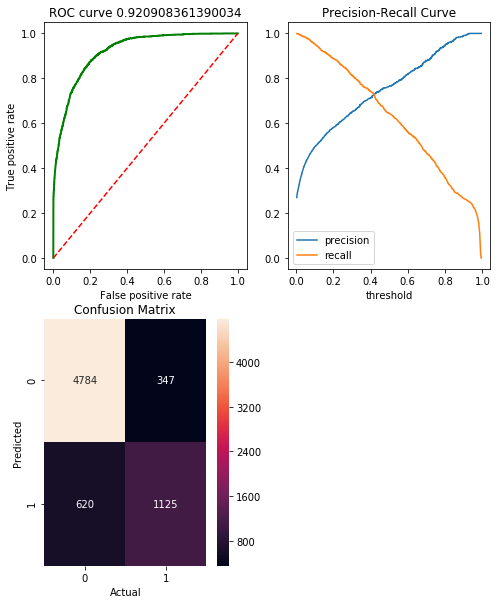

In [83]:
plot_model(get_grid('gbc'))

LR
Training Score: 0.8471495055264688
Testing Score: 0.8426410703897614
Precision Score: 0.7359430604982207
Recall Score: 0.5925501432664756
F1 Score: 0.6565079365079365


True

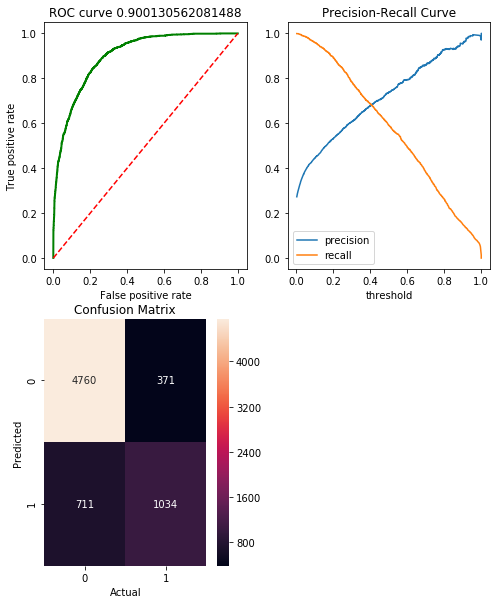

In [73]:
plot_model(get_grid('lr'))

BC
Training Score: 0.977021524141943
Testing Score: 0.8406050029086678
Precision Score: 0.7034482758620689
Recall Score: 0.6429799426934097
F1 Score: 0.6718562874251497


True

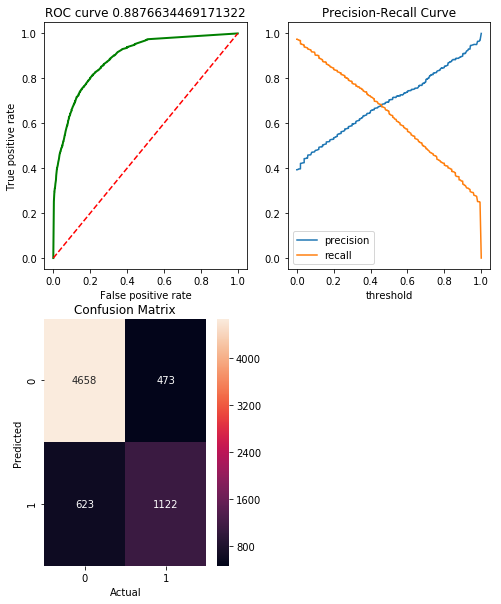

In [77]:
plot_model(get_grid('bc'))

RF
Training Score: 0.8632926119837114
Testing Score: 0.8497673065735893
Precision Score: 0.7875605815831987
Recall Score: 0.5587392550143266
F1 Score: 0.6537043245055313


True

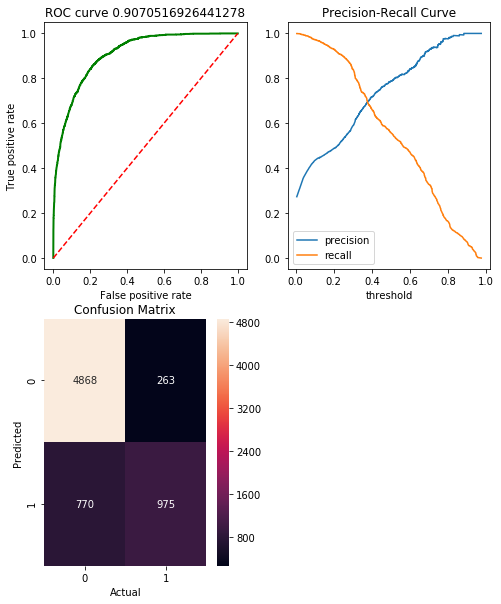

In [78]:
plot_model(get_grid('rf'))

### Smoted Models

GBC
Training Score: 0.9181297958121992
Testing Score: 0.8554392088423503
Precision Score: 0.7057534246575342
Recall Score: 0.73810888252149
F1 Score: 0.7215686274509805


True

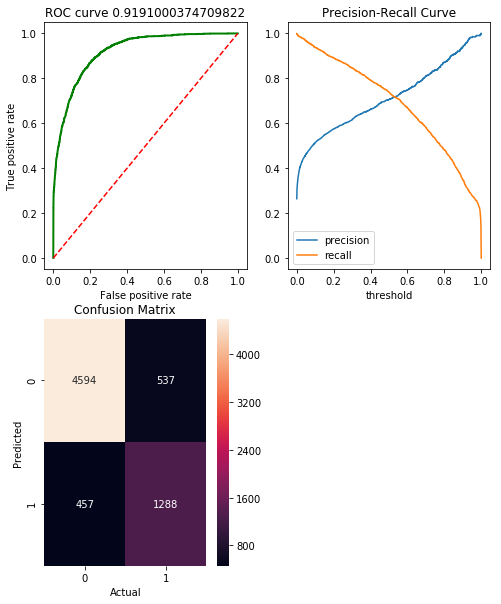

In [82]:
plot_model(get_grid_smoted('gbc'))

LR
Training Score: 0.8320978020548836
Testing Score: 0.8036649214659686
Precision Score: 0.5792218210990774
Recall Score: 0.8275071633237823
F1 Score: 0.6814535158093441


True

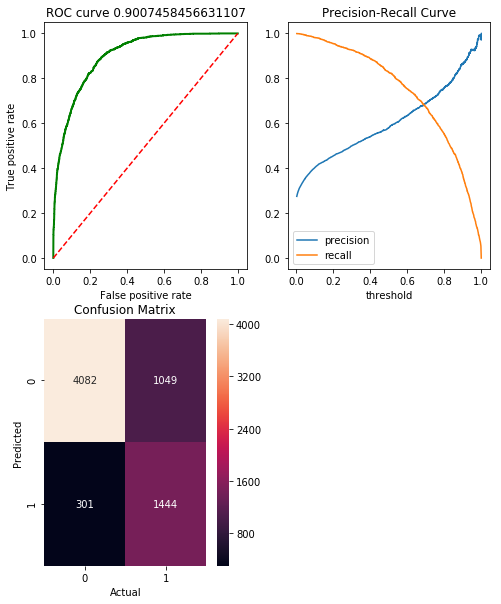

In [79]:
plot_model(get_grid_smoted('lr'))

BC
Training Score: 0.9833528417219405
Testing Score: 0.8305700988947062
Precision Score: 0.6740696278511404
Recall Score: 0.6435530085959885
F1 Score: 0.6584579302257403


True

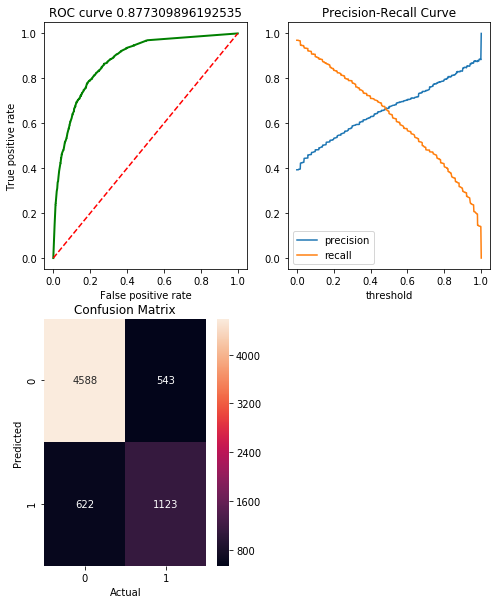

In [80]:
plot_model(get_grid_smoted('bc'))

RF
Training Score: 0.9751918324879698
Testing Score: 0.8384235020360675
Precision Score: 0.6776905829596412
Recall Score: 0.692836676217765
F1 Score: 0.6851799376593936


True

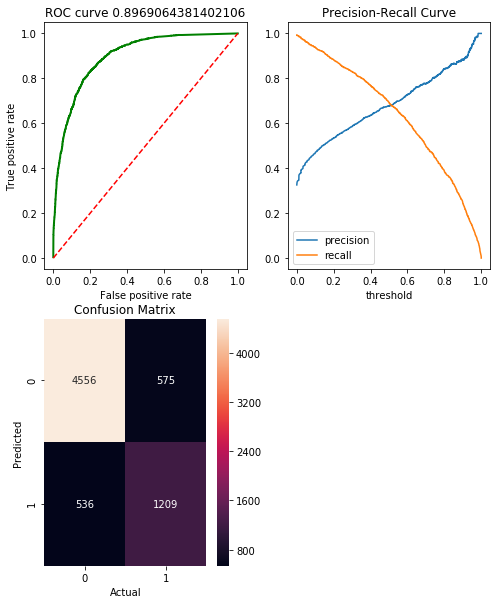

In [81]:
plot_model(get_grid_smoted('rf'))

In [109]:
X_train.shape

(20628, 62)

In [108]:
X_train_smoted.shape

(33848, 104)

In [1]:
#  Playing with a neural network - ran out of time

from keras.layers import Dense, Dropout, Input
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
x = Dense(254, activation='relu')(inputs)
x = Dropout(0.4)(x)
x = Dense(254, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

/Users/tarekbarnes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 62)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 254)               16002     
_________________________________________________________________
dropout_1 (Dropout)          (None, 254)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 254)               64770     
_________________________________________________________________
dropout_2 (Dropout)          (None, 254)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 255       
Total params: 81,027
Trainable params: 81,027
Non-trainable params: 0
_________________________________________________________________


In [16]:
X.shape[1]

62

In [12]:
model.fit(X_train, y_train)

Epoch 1/1
20628/20628 [==============================] - 2s 118us/step - loss: 11.8942


In [24]:
preds = model.predict(X_train)
preds[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [26]:
# keras.engine.input_layer.Input()

from keras.engine import input_layer

input_layer.Input()

AssertionError: Please provide to Input either a `shape` or a `batch_shape` argument. Note that `shape` does not include the batch dimension.

### Messing Around

In [40]:
lr = LogisticRegression()
# lr.fit(X_train, y_train)
print("Training score: {}".format(lr.score(X_test, y_test)))
print("Testing score: {}".format(lr.score(X_train, y_train)))

rfe = RFE(lr, 10)
rfe.fit(X_train, y_train)

In [27]:
rf_model = ('forest', RandomForestClassifier)

rf_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
        }
    
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

name, rf_mod = rf_model
rf_grid = GridSearchCV(rf_mod(), rf_params)
rf_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [1, 2, 3, 4, 5], 'min_samples_leaf': [3, 6, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
rf_grid.score(X_train_scaled, y_train), rf_grid.score(X_test_scaled, y_test)

(0.8336059413819018, 0.8317199310436282)

In [41]:
bc_model = ('bc', BaggingClassifier)

bc_params = {'n_estimators': [50, 100, 200]}
#         'scale__with_mean': [True, False],     # bagging classifier
#         'scale__with_std': [True, False]}
    
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

name, bc_mod = bc_model
bc_grid = GridSearchCV(bc_mod(base_estimator=DecisionTreeClassifier(), n_jobs=-1), bc_params)
bc_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            ..._estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
bc_grid.score(X_train_scaled, y_train), bc_grid.score(X_test_scaled, y_test)

(0.9999557932894213, 0.8561198780002652)